# Full-disk synthesis

### Load atmosphere from PSI's MAS MHD model

Includes temperature, magnetic field vector, and density distributions in CGS units

In [2]:
import models.MAS.mas as mas
from sunpy.coordinates import sun
import numpy as np
from numba import njit, prange
import sunpy.sun.constants as constants
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
np.seterr(divide='ignore', invalid='ignore')

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

# Setup PSI model
print("Importing coronal model... ", end="")
# modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = mas.Model('./models/MAS/corona_cr2282/') #cr2194
print("done")

# Setup observer
print("Initializing observer and image plane... ", end="")
crn= sun.carrington_rotation_number('2024-04-08T12:00:00.000') #2247 # '2017-08-21T12:00:00.000'
print(crn)
crt = sun.carrington_rotation_time(crn)
obsLon = sun.L0(crt).rad
obsLat = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc = sun.angular_radius(crt).value
rObs = Obs_Sun_AU * constants.astronomical_unit.value/constants.radius.value
thetaObs = np.pi / 2 - obsLat
phiObs = obsLon

# Create image
rsunarc = 960
arcsamp = 20.
arc = np.linspace(-3 * rsunarc, 3 * rsunarc, int(6 * rsunarc / arcsamp))
zza, yya = np.meshgrid(arc, arc, indexing='ij')
zza = np.flipud(zza)
mask_ondisk = (np.hypot(zza, yya) > rsunarc).astype(float)

# Project to solar tangent plane
yy = rObs * np.tan(np.deg2rad(yya / 3600.))
zz = rObs * np.tan(np.deg2rad(zza / 3600.))
rr = np.hypot(yy, zz)
xx = np.zeros_like(rr)
xx[rr < 1] = np.sqrt(1 - rr[rr < 1]**2)
print("done")

# Create rays
print("Creating rays through image plane... ", end="")
rot = euler_ry(thetaObs - np.pi/2) @ euler_rz(phiObs)
starts = (rot @ np.stack([xx.ravel(), yy.ravel(), zz.ravel()])).T
obs_vec = rObs * np.array([
    np.sin(thetaObs) * np.cos(phiObs),
    np.sin(thetaObs) * np.sin(phiObs),
    np.cos(thetaObs)
])
los = obs_vec - starts
los /= np.linalg.norm(los, axis=1, keepdims=True)

start_r = 2.0 # start this many solar radii from sun's center
deltaR_forward = corona.rs - start_r
deltaR_forward = deltaR_forward[deltaR_forward >= 0]
deltaR_bidirectional = np.cumsum(np.diff(corona.rs))
deltaR_bidirectional = np.hstack([-deltaR_bidirectional[::-1], deltaR_bidirectional])
deltaR = np.zeros((len(deltaR_bidirectional), starts.shape[0]))
on_disk = np.linalg.norm(starts, axis=1) <= 1.0
deltaR[:len(deltaR_forward), on_disk] = deltaR_forward[:, None]
deltaR[:len(deltaR_bidirectional), ~on_disk] = deltaR_bidirectional[:, None]
rays_xyz = starts[None] + deltaR[:, :, None] * los[None]

# Convert to spherical coordinates
r = np.linalg.norm(rays_xyz, axis=2)
theta = np.arccos(rays_xyz[:, :, 2] / r)
phi = np.mod(np.arctan2(rays_xyz[:, :, 1], rays_xyz[:, :, 0]), 2 * np.pi)
rays_sph = np.stack([phi, theta, r], axis=-1).reshape(-1, 3)
print('done')

# Interpolation
print("Interpolating plasma and magnetic field values... ", end="")
def interp(field, name):
    print(f"({name}) ", end="")
    return rgi(
        (corona.phis, corona.thetas, corona.rs),
        field,
        method='linear',
        fill_value=0.0,
        bounds_error=False
    )(rays_sph).reshape(r.shape)
bx_rays = interp(corona.bx, "bx")
by_rays = interp(corona.by, "by")
bz_rays = interp(corona.bz, "bz")
ne_rays = interp(corona.ne, "density")
temp_rays = interp(corona.temp, "temp")
print("done")

# B-field projections
print("Projecting B-fields along LOS... ", end="")
bvec = np.stack([bx_rays, by_rays, bz_rays], axis=-1)
lvec = rays_xyz / (np.linalg.norm(rays_xyz, axis=2, keepdims=True) + 1e-15)
blos_rays = np.sum(bvec * lvec, axis=2)
btot_rays = np.linalg.norm(bvec, axis=2)
# Step sizes
dray = np.linalg.norm(np.diff(rays_xyz, axis=0), axis=2) * constants.radius.value * 100.  # solar radius in cm
print("done")

Importing coronal model... done
Initializing observer and image plane... 2282.9729816187023
done
Creating rays through image plane... done
Interpolating plasma and magnetic field values... (bx) (by) (bz) (density) (temp) done
Projecting B-fields along LOS... done


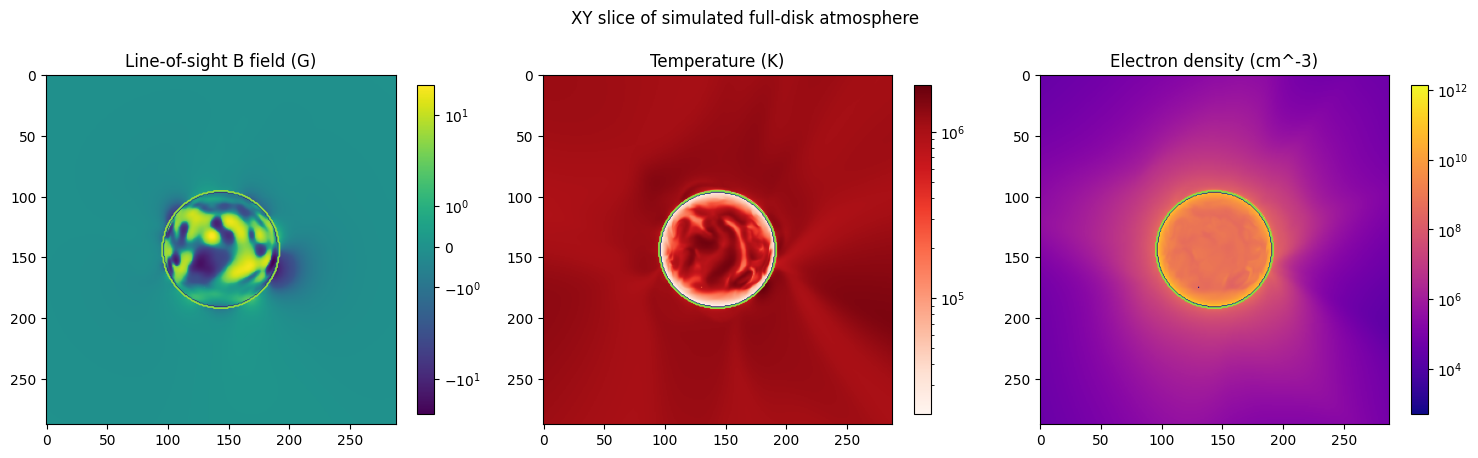

In [58]:
x_idx = 290
blos_shaped = blos_rays[x_idx, :].reshape(*yya.shape)*mask_ondisk
temp_shaped = temp_rays[x_idx, :].reshape(*yya.shape)*mask_ondisk
ne_shaped = ne_rays[x_idx, :].reshape(*yya.shape)*mask_ondisk

x_idx = 0
blos_shaped_ondisk = blos_rays[x_idx, :].reshape(*yya.shape)*(1-mask_ondisk)
temp_shaped_ondisk = temp_rays[x_idx, :].reshape(*yya.shape)*(1-mask_ondisk)
ne_shaped_ondisk = ne_rays[x_idx, :].reshape(*yya.shape)*(1-mask_ondisk)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im0 = axs[0].imshow(blos_shaped + blos_shaped_ondisk, norm='symlog')
axs[0].contour(mask_ondisk, linewidths = 1)
axs[0].set_title(f'Line-of-sight B field (G)')
plt.colorbar(im0, shrink=0.7)
im1 = axs[1].imshow(temp_shaped_ondisk + temp_shaped, norm='log', cmap='Reds')
axs[1].contour(mask_ondisk, linewidths = 1)
axs[1].set_title(f'Temperature (K)')
plt.colorbar(im1, shrink=0.7)
im2 = axs[2].imshow(ne_shaped + ne_shaped_ondisk, norm='log', cmap='plasma')
axs[2].contour(mask_ondisk, linewidths = 1)
axs[2].set_title(f'Electron density (cm^-3)')
plt.colorbar(im2, shrink=0.7)
plt.tight_layout()
plt.suptitle('XY slice of simulated full-disk atmosphere')
plt.show()

### Synthesis

In [2]:
import pysolrad

v = 1e10
rays = pysolrad.RayCollection(temp_rays[:-1], btot_rays[:-1], blos_rays[:-1], ne_rays[:-1], dray, axis=0) # rays can be 2D or 3D - 2D is useful for non-cartesian coordinate systems like polar
img = pysolrad.synthesize(rays, v, dogyro=False).reshape(*yya.shape) # since we only had 2D array of rays, we need to reshape the resulting image

[⎯] - creating rays... 5/5 quantities - done
[⎯] - synthesizing... - done


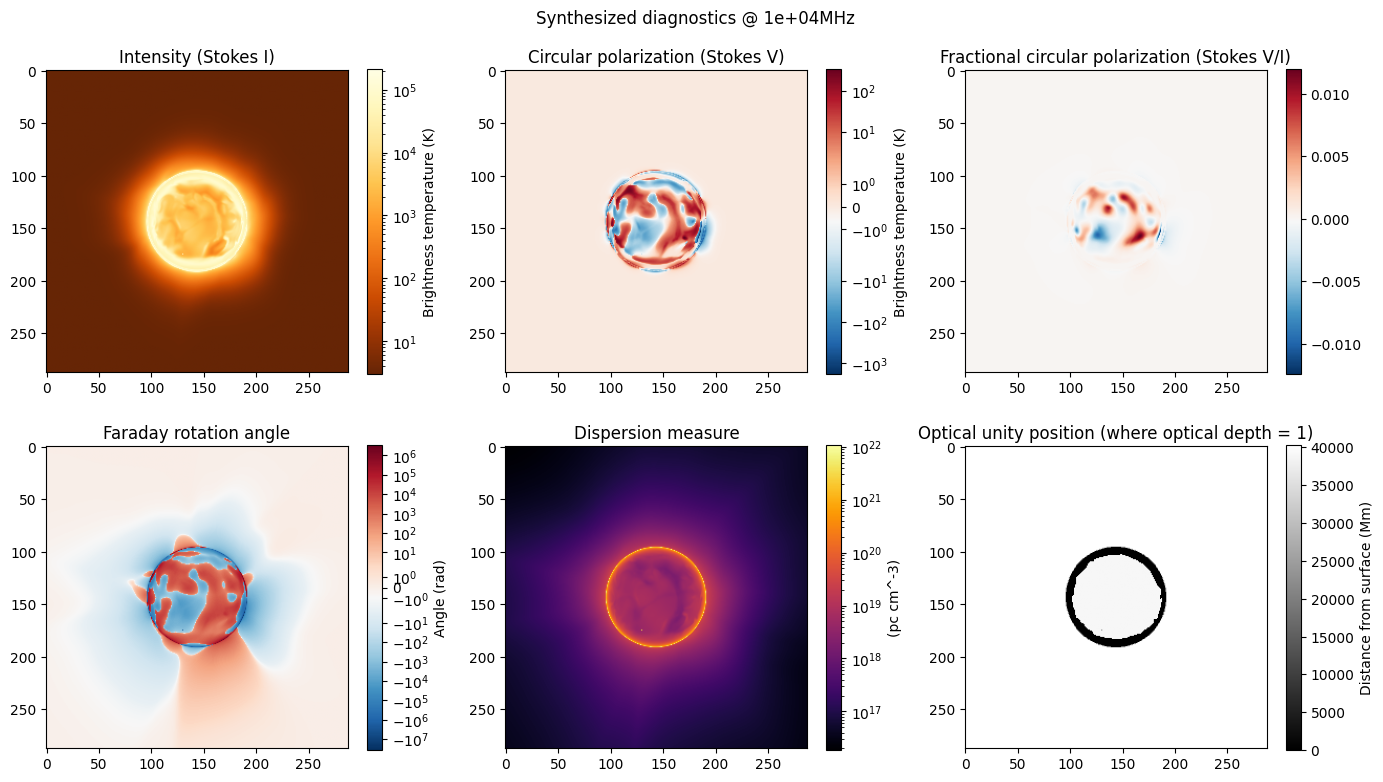

In [3]:
def plot_diagnostics(img):
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    im0 = axs[0, 0].imshow(img.I, cmap='YlOrBr_r', norm='log')
    axs[0, 0].set_title('Intensity (Stokes I)')
    fig.colorbar(im0, ax=axs[0, 0], label='Brightness temperature (K)', shrink=0.9)

    im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
    axs[0, 1].set_title('Circular polarization (Stokes V)')
    fig.colorbar(im1, ax=axs[0, 1], label='Brightness temperature (K)', shrink=0.9)

    im4 = axs[0, 2].imshow(img.V/img.I, cmap='RdBu_r')
    axs[0, 2].set_title('Fractional circular polarization (Stokes V/I)')
    fig.colorbar(im4, ax=axs[0, 2], label='', shrink=0.9)

    im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
    axs[1, 0].set_title('Faraday rotation angle')
    fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)', shrink=0.9)

    im3 = axs[1, 1].imshow(img.disp, cmap='inferno', norm='log')
    axs[1, 1].set_title('Dispersion measure')
    fig.colorbar(im3, ax=axs[1, 1], label='(pc cm^-3)', shrink=0.9)

    im4 = axs[1, 2].imshow(img.unity.to('Mm'), cmap='gray')
    axs[1, 2].set_title('Optical unity position (where optical depth = 1)')
    fig.colorbar(im4, ax=axs[1, 2], label='Distance from surface (Mm)', shrink=0.9)

    plt.suptitle(f'Synthesized diagnostics @ {str(pysolrad.Quantity(img.v, 'Hz').to('MHz'))}')
    plt.tight_layout()
    plt.show()

plot_diagnostics(img)

### 2D magnetic field inversion

$P=n\frac{2.8\times 10^6}{v}B_{\text{los}}$ where spectral index $n\equiv -\frac{\partial{\log T_b}}{\partial{\log v}}$ and $P=\frac{V}{I}$

from Chapter 6 of [Solar and Space Weather Radio Physics](https://drive.google.com/file/d/1nPEj6RIKA_eOtnwODCnCgedhT0LWunM2/view)

Given Stokes IV maps (in this case, from synthesized Stokes maps), can we predict emissivity-weighted BLOS?

In [4]:
freq_range = np.logspace(5, 12, 10) # frequencies to sample
images = pysolrad.synthesize_range(rays, freq_range).reshape(*yya.shape) # reshaping ImageCollection reshapes all of its images
inverted_blos_collection = pysolrad.invert_blos(images).reshape(10, *yya.shape) # first axis is frequencies
blos_at_unity_collection = pysolrad.get_quantity_at_unity(rays, 'blos', images).reshape(10, *yya.shape)

[⎯] - synthesizing... 10/10 frequencies - done


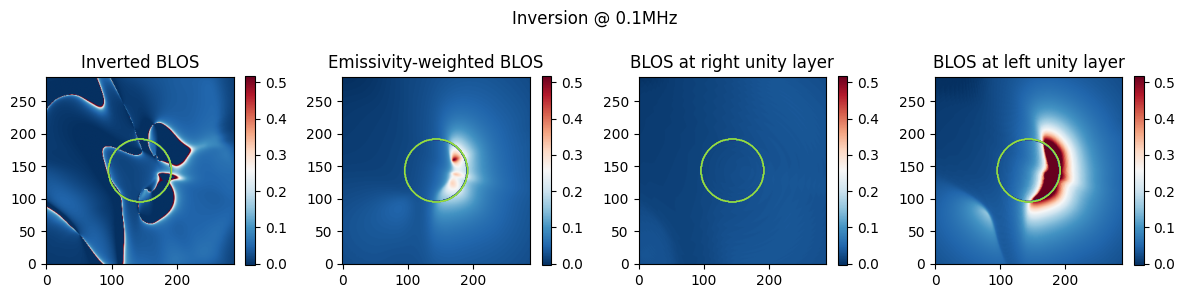

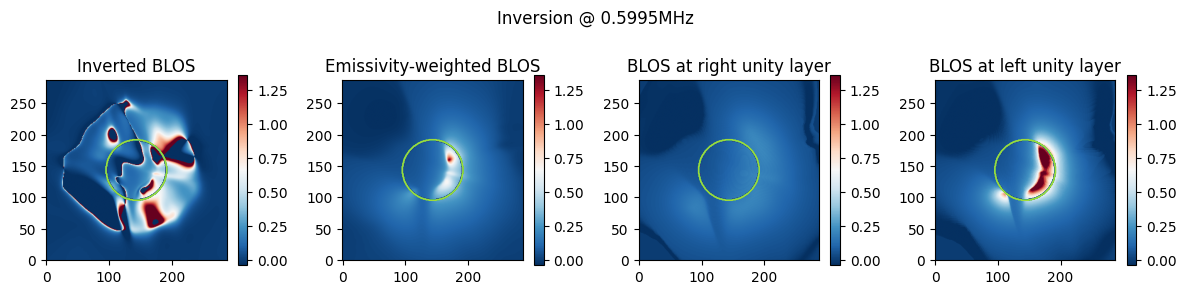

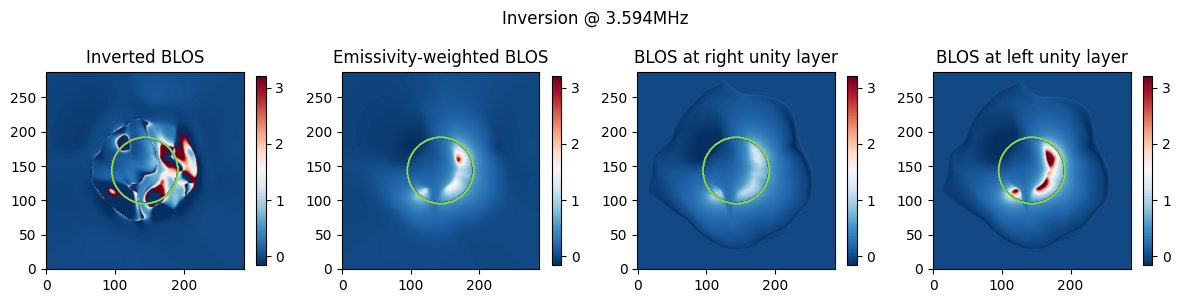

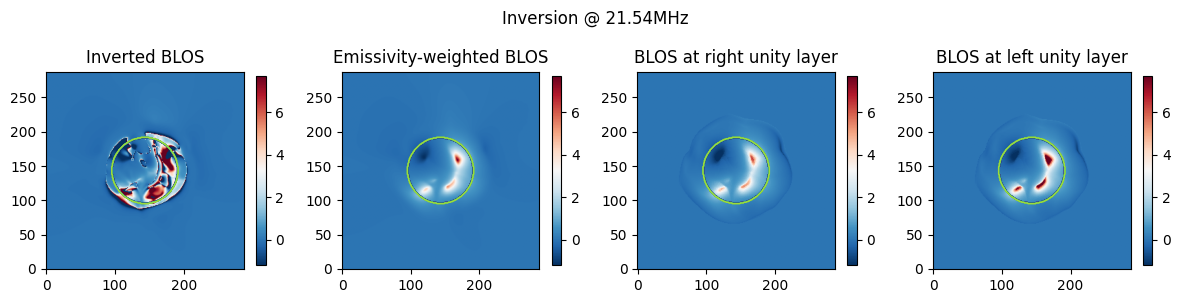

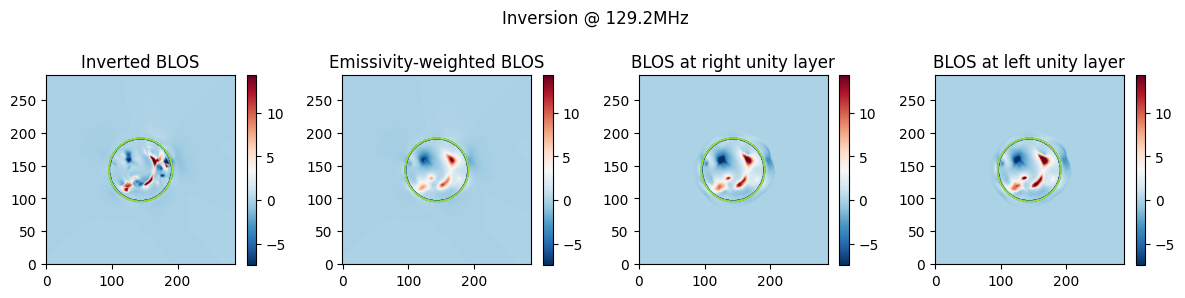

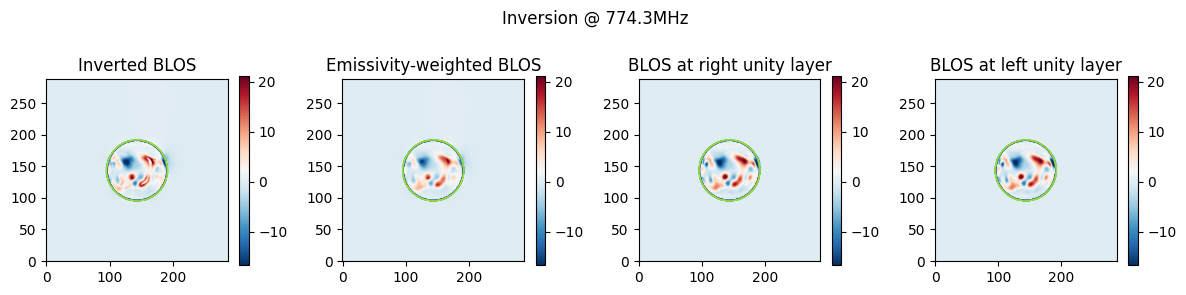

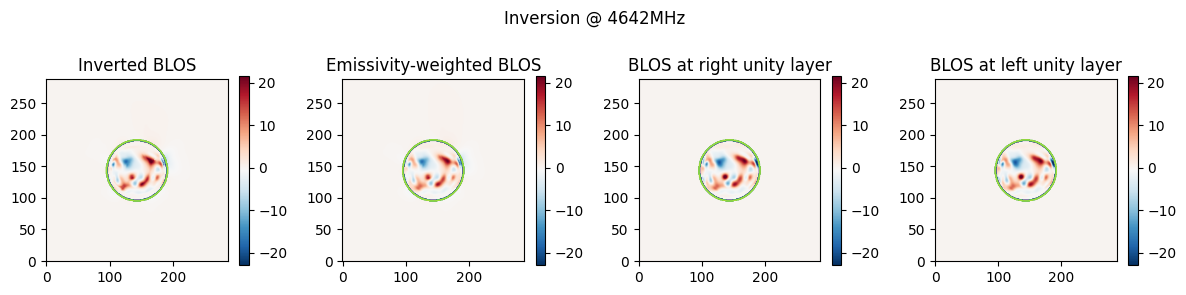

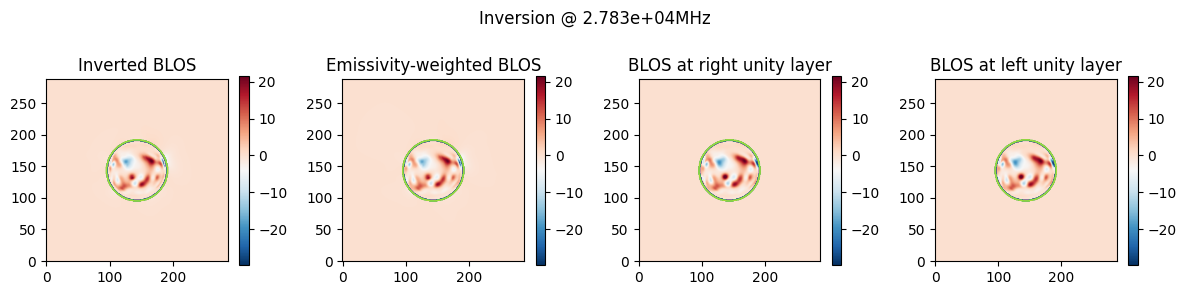

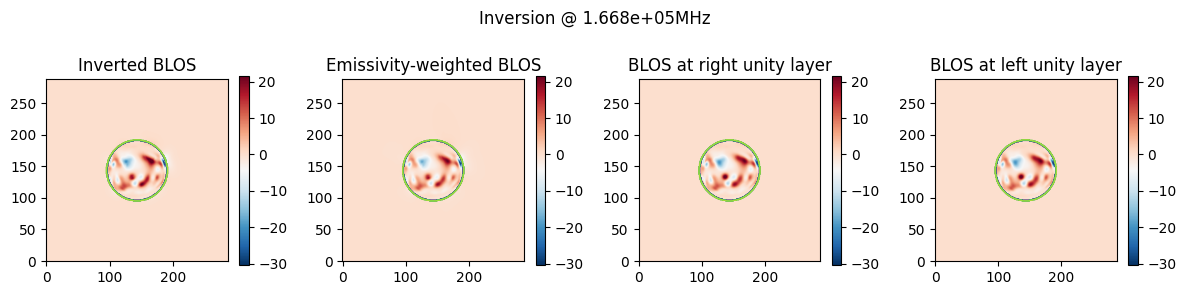

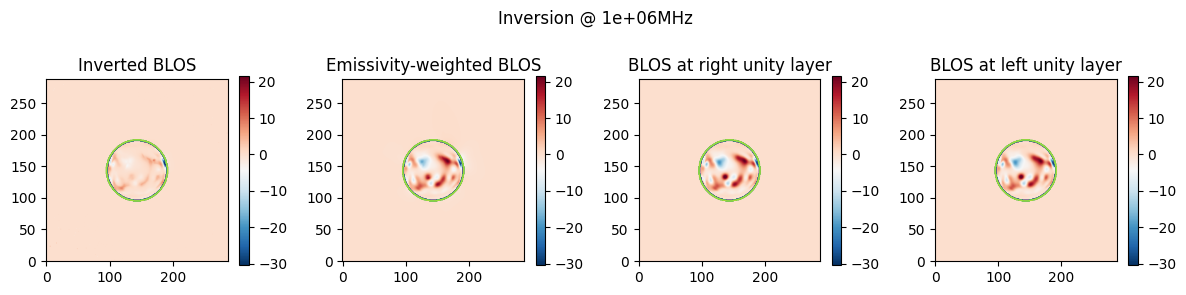

In [5]:
for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    inverted_blos = inverted_blos_collection[idx]
    blos_at_unity = blos_at_unity_collection[idx]
    weighted_blos = images[idx].weighted_blos
    im0 = axs[0].imshow(inverted_blos, origin='lower', cmap='RdBu_r', vmax=weighted_blos.max(), vmin=weighted_blos.min())
    axs[0].set_title(f"Inverted BLOS")
    fig.colorbar(im0, ax=axs[0], shrink=0.8)
    axs[0].contour(mask_ondisk, linewidths=1)
    im1 = axs[1].imshow(weighted_blos, origin='lower', cmap='RdBu_r', vmax=weighted_blos.max(), vmin=weighted_blos.min())
    axs[1].set_title(f"Emissivity-weighted BLOS")
    axs[1].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im1, ax=axs[1], shrink=0.8)
    im2 = axs[2].imshow(blos_at_unity_collection[idx].right, origin='lower', cmap='RdBu_r', vmax=weighted_blos.max(), vmin=weighted_blos.min())
    axs[2].set_title(f"BLOS at right unity layer")
    axs[2].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im2, ax=axs[2], shrink=0.8)
    im3 = axs[3].imshow(blos_at_unity_collection[idx].left, origin='lower', cmap='RdBu_r', vmax=weighted_blos.max(), vmin=weighted_blos.min())
    axs[3].set_title(f"BLOS at left unity layer")
    axs[3].contour(mask_ondisk, linewidths=1)
    fig.colorbar(im3, ax=axs[3], shrink=0.8)
    plt.suptitle(f"Inversion @ {str(pysolrad.Quantity(images.v[idx], 'Hz').to('MHz'))}")
    plt.tight_layout()
    plt.show()